<!-- # MNIST with SciKit-Learn and PyTroch -->
# Neural Networks with PyTorch

<a target="_blank" href="https://colab.research.google.com/github/AI4EPS/EPS88_PyEarth/blob/master/docs/lectures/10_neural_networks2.ipynb">
<img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>  


**Note**: If you are running this in [a colab notebook](https://colab.research.google.com/github/skorch-dev/skorch/blob/master/notebooks/MNIST.ipynb), we recommend you enable a free GPU by going:

> **Runtime**   →   **Change runtime type**   →   **Hardware Accelerator: GPU**

GPUs are commonly used to accelerate training of deep learning models. If you want to learn more about GPUs or even TPUs for training nerual networks, check out this short [video](https://youtu.be/Jr1cC7pyZME?si=SDRIc8QWgY0masna).

This notebooks shows how to define and train a simple modern Neural Network with PyTorch.

We will use the MNIST dataset, which is a dataset of 60,000 28x28 grayscale images of the 10 digits, along with a test set of 10,000 images.

The dateaset is very popular and is often used as a "Hello World" example in the field of Machine Learning. It is a good dataset to start with, as it is small and easy to work with.

For this small dataset, we will use the socalled "LeNet" architecture is used here. It is a simple convolutional neural network, which was introduced by Yann LeCun in 1998. It is a simple and effective architecture for small image datasets. 
You can read more about the model on [Wikipedia](https://en.wikipedia.org/wiki/LeNet).

<!-- ![](https://raw.githubusercontent.com/zhuwq0/images/main/lenet.png) -->
<img src="https://raw.githubusercontent.com/zhuwq0/images/main/lenet.png" width="50%">



In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

In [2]:
## Set random seed
torch.manual_seed(0)
torch.cuda.manual_seed(0)
np.random.seed(0)

## Loading Data
Using SciKit-Learns ```fetch_openml``` to load MNIST data.

Each image of the MNIST dataset is encoded in a 784 dimensional vector, representing a 28 x 28 pixel image.

Each pixel has a value between 0 and 255, corresponding to the grey-value of a pixel.


In [3]:
mnist = fetch_openml('mnist_784', as_frame=False)

In [4]:
print(f"MNIST data shape: {mnist.data.shape}, data type: {mnist.data.dtype}")
print(f"MNIST target shape: {mnist.target.shape}, target type: {mnist.target.dtype}")

MNIST data shape: (70000, 784), data type: int64
MNIST target shape: (70000,), target type: object


## Preprocessing Data

The above ```featch_mldata``` method to load MNIST returns ```data``` and ```target``` as ```uint8``` which we convert to ```float32``` and ```int64``` respectively.

To avoid big weights that deal with the pixel values from between [0, 255], we scale `X` down. A commonly used range is [0, 1].


In [5]:
## Make sure the data is float32 and the labels are int64
X = mnist.data.astype('float32')
y = mnist.target.astype('int64')

## Normalize the data to [0, 1]. Hint: the raw pixel values are in [0, 255].
X /= 255.0
print(f"{X.min() = }, {X.max() = }")

X.min() = 0.0, X.max() = 1.0


Same as prevoious lectures, let split the data into training and testing sets.

In [6]:
## Split data into training and testing sets using 30% of the data for testing and random seed 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Visualize a selection of training images and their labels


In [7]:
## Define a function to plot a selection of images and their labels
def plot_example(X, y, n_samples=10):
    """Plot the first n_samples images and their labels in a row."""
    fig, axes = plt.subplots(1, n_samples, figsize=(2*n_samples, 4))
    for i, ax in enumerate(axes):
        ax.imshow(X[i].reshape(28, 28), cmap='gray')
        ax.set_title(y[i], fontsize=32)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

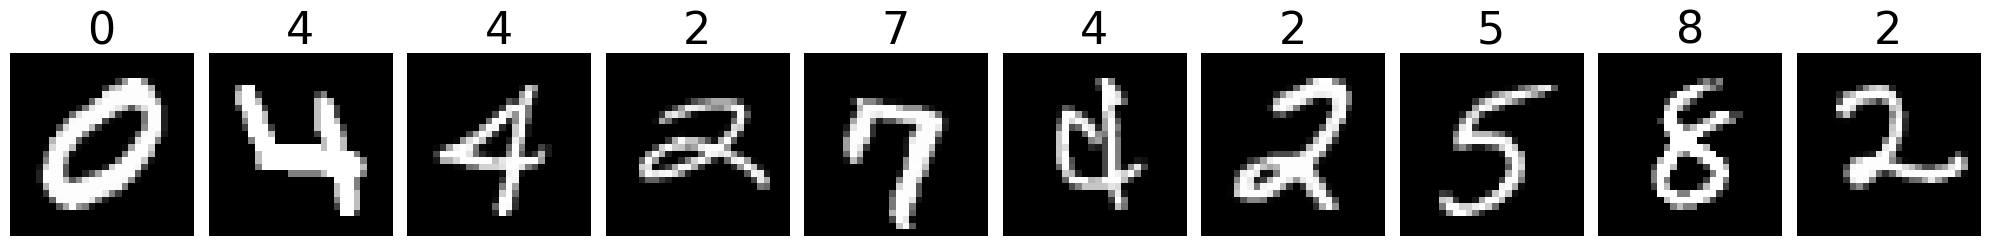

In [8]:
## Plot the first 10 images from the training set
plot_example(X_train, y_train, n_samples=10)

## Build Neural Network with PyTorch

In the previous lecture, we have built a simple fully connected neural network with one hidden layer for both linear regression and classification tasks. Let's first try a similar network for the classification task of MNIST.

Note the dataset is much larger than our previous examples, so we need to adjust the network size accordingly.
(It is still tiny compared to modern standards)

Let's think about the network architecture:

- Input layer: 784 dimensions (28x28). This is defined by the MNIST data shape.
- Hidden layer: 98 (= 784 / 8). This is a free parameter that we can choose.
- Output layer: 10 neurons, representing digits 0 - 9. This is defined by the number of classes in the dataset.

- Prepare the data for training and testing

In [9]:
## Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.int64)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.int64)

- Build a simple fully connected neural network in PyTorch's framework.

In [10]:
## Define the network architecture: A simple fully connected neural network
class FCN(nn.Module):
    def __init__(
            self,
            input_dim=28*28,
            hidden_dim=28*4,
            output_dim=10,
            dropout=0.5,
    ):
        super(FCN, self).__init__()
        ## Define the neural network layers
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, **kwargs):
        ## Apply the neural network layers
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

Training Epoch 1/15: 100%|██████████| 382/382 [00:04<00:00, 84.52it/s] 


Epoch 1/15: Loss: 0.6224


Training Epoch 2/15: 100%|██████████| 382/382 [00:03<00:00, 97.92it/s] 


Epoch 2/15: Loss: 0.3276


Training Epoch 3/15: 100%|██████████| 382/382 [00:03<00:00, 104.05it/s]


Epoch 3/15: Loss: 0.2684


Training Epoch 4/15: 100%|██████████| 382/382 [00:04<00:00, 93.66it/s] 


Epoch 4/15: Loss: 0.2408


Training Epoch 5/15: 100%|██████████| 382/382 [00:03<00:00, 99.05it/s] 


Epoch 5/15: Loss: 0.2120


Training Epoch 6/15: 100%|██████████| 382/382 [00:03<00:00, 102.76it/s]


Epoch 6/15: Loss: 0.1991


Training Epoch 7/15: 100%|██████████| 382/382 [00:03<00:00, 100.87it/s]


Epoch 7/15: Loss: 0.1863


Training Epoch 8/15: 100%|██████████| 382/382 [00:03<00:00, 103.79it/s]


Epoch 8/15: Loss: 0.1715


Training Epoch 9/15: 100%|██████████| 382/382 [00:04<00:00, 82.94it/s] 


Epoch 9/15: Loss: 0.1644


Training Epoch 10/15: 100%|██████████| 382/382 [00:03<00:00, 126.21it/s]


Epoch 10/15: Loss: 0.1596


Training Epoch 11/15: 100%|██████████| 382/382 [00:04<00:00, 77.86it/s] 


Epoch 11/15: Loss: 0.1561


Training Epoch 12/15: 100%|██████████| 382/382 [00:04<00:00, 82.26it/s] 


Epoch 12/15: Loss: 0.1450


Training Epoch 13/15: 100%|██████████| 382/382 [00:03<00:00, 97.77it/s] 


Epoch 13/15: Loss: 0.1407


Training Epoch 14/15: 100%|██████████| 382/382 [00:04<00:00, 89.12it/s] 


Epoch 14/15: Loss: 0.1392


Training Epoch 15/15: 100%|██████████| 382/382 [00:03<00:00, 97.44it/s] 


Epoch 15/15: Loss: 0.1344


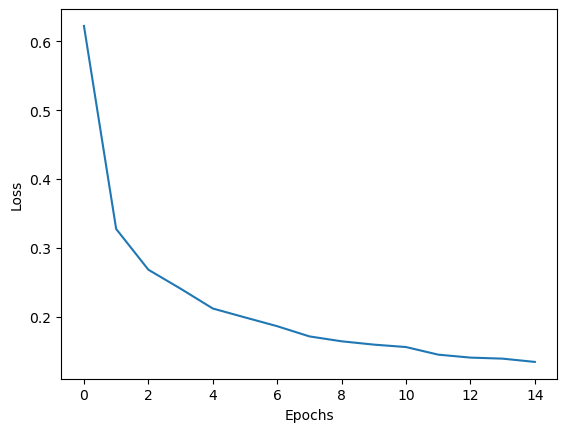

In [11]:
## Define the model dimensions
mnist_dim = X.shape[1]
hidden_dim = int(mnist_dim/8)
output_dim = len(np.unique(mnist.target))

## Define the model, loss function, and optimizer
model = FCN(input_dim=mnist_dim, hidden_dim=hidden_dim, output_dim=output_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## Define the device to choose the fastest for training
## MPS for Apple Silicon, CUDA for NVidia GPUs, and CPU otherwise
device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'

## Define fit function
def fit(model, X_train, y_train, epochs=100):
    dataloader = DataLoader(dataset=TensorDataset(X_train, y_train), batch_size=128, shuffle=True, drop_last=True)
    model.to(device)

    ## set the model to training mode
    model.train()
    losses = []
    for epoch in range(epochs):
        loss = 0
        for X_train, y_train in tqdm(dataloader, desc=f'Training Epoch {epoch+1}/{epochs}'):
            X_train = X_train.to(device)
            y_train = y_train.to(device)
            ## zero the gradients
            optimizer.zero_grad()

            ## get the model predictions
            outputs = model(X_train)
            ## calculate the loss
            batch_loss = criterion(outputs, y_train)
            batch_loss.backward()
            ## update the weights
            optimizer.step()
            
            loss += batch_loss.item()

        # average loss per batch
        loss = loss / len(dataloader)
        losses.append(loss)

        print(f'Epoch {epoch+1}/{epochs}: Loss: {loss:.4f}')

    return losses

## Define predict function
def predict(model, X):
    dataloader = DataLoader(dataset=TensorDataset(X), batch_size=128, drop_last=False)
    ## set the model to evaluation mode
    model.eval()
    device = next(model.parameters()).device
    with torch.no_grad():
        predicted = []
        for X, in tqdm(dataloader, desc='Predicting'):
            X = X.to(device)
            
            ## get the model predictions
            outputs = model(X)

            _, predicted_batch = torch.max(outputs, 1)
            predicted.append(predicted_batch.cpu())
    return torch.cat(predicted)

## Train the model
losses = fit(model, X_train_tensor, y_train_tensor, epochs=15)

## Plot the loss
plt.figure()
plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

- Evaluate the model on the test set. This is same as the previous lecture.

Predicting: 100%|██████████| 165/165 [00:00<00:00, 224.32it/s]


Accuracy: 0.9686


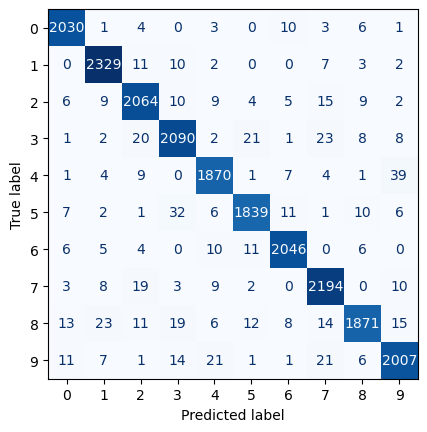

In [12]:
## Predict on the test set
y_pred_tensor = predict(model, X_test_tensor)
y_pred = y_pred_tensor.numpy()

## Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

## Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=np.arange(len(np.unique(y))))
disp.plot(cmap=plt.cm.Blues, values_format='d', colorbar=False);

What accuracy did you get? Is it above 95%?

An accuracy of above 95% for a network with only one hidden layer is not too bad.

Let's take a look at some predictions that went wrong:

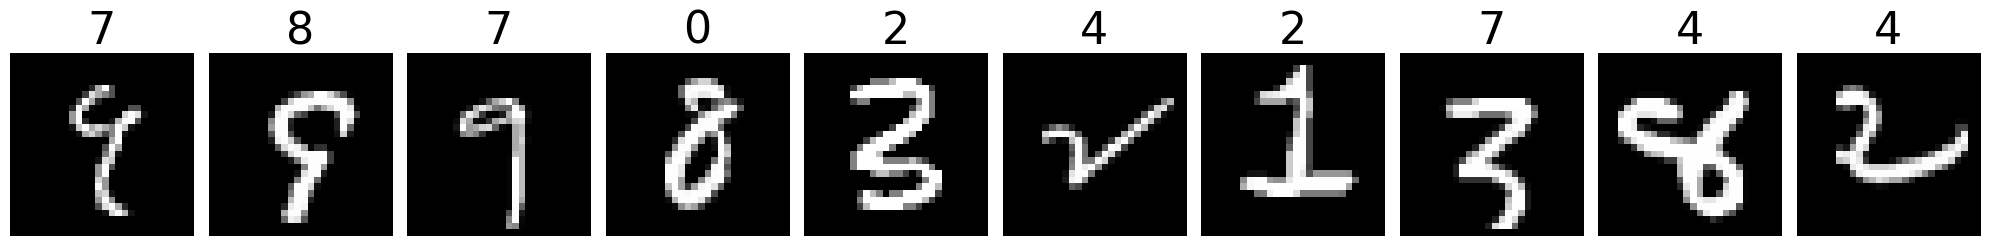

In [13]:
error_mask_fcn = y_pred != y_test
plot_example(X_test[error_mask_fcn], y_pred[error_mask_fcn], n_samples=10)

Are these errors reasonable? 

# Convolutional Network

To further improve the performance, let's try a convolutional neural network (CNN) for MNIST. 

The 2D convolutional layer expects a 4 dimensional tensor as input. The dimensions represent:
* Batch size
* Number of channel
* Height
* Width

So we need to reshape the MNIST data to have the right shape.
MNIST data has only one channel. As stated above, each MNIST vector represents a 28x28 pixel image. Hence, the resulting shape for PyTorch tensor needs to be (x, 1, 28, 28). 

- Prepare the data for training and testing

In [14]:
## Convert data to PyTorch tensors and reshape to 4D tensor (batch_size, channel, height, width)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).reshape(-1, 1, 28, 28)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).reshape(-1, 1, 28, 28)
y_train_tensor = torch.tensor(y_train, dtype=torch.int64)
y_test_tensor = torch.tensor(y_test, dtype=torch.int64)

- Build a simple convolutional neural network in PyTorch's framework.


In [15]:
## Define the network architecture: A simple convolutional neural network
class CNN(nn.Module):
    def __init__(self, input_dim=28*28, hidden_dim=112, output_dim=10, dropout=0.5):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv1_drop = nn.Dropout2d(p=dropout)
        self.conv2_drop = nn.Dropout2d(p=dropout)
        num_features = 64 * int((input_dim**0.5 // 4 - 2)**2)
        self.fc1 = nn.Linear(num_features, hidden_dim) # 1600 = number channels * width * height
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.fc1_drop = nn.Dropout(p=dropout)

    def forward(self, x):
    
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.conv1_drop(x)

        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.conv2_drop(x)
        
        # flatten over channel, height and width        
        x = x.view(x.size(0), -1)
        
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc1_drop(x)
        x = self.fc2(x)

        return x

Training Epoch 1/15: 100%|██████████| 382/382 [00:08<00:00, 47.01it/s]


Epoch 1/15: Loss: 0.6035


Training Epoch 2/15: 100%|██████████| 382/382 [00:09<00:00, 38.57it/s]


Epoch 2/15: Loss: 0.2225


Training Epoch 3/15: 100%|██████████| 382/382 [00:07<00:00, 50.48it/s]


Epoch 3/15: Loss: 0.1759


Training Epoch 4/15: 100%|██████████| 382/382 [00:07<00:00, 54.05it/s]


Epoch 4/15: Loss: 0.1474


Training Epoch 5/15: 100%|██████████| 382/382 [00:08<00:00, 46.59it/s]


Epoch 5/15: Loss: 0.1295


Training Epoch 6/15: 100%|██████████| 382/382 [00:06<00:00, 57.71it/s]


Epoch 6/15: Loss: 0.1206


Training Epoch 7/15: 100%|██████████| 382/382 [00:05<00:00, 70.02it/s]


Epoch 7/15: Loss: 0.1133


Training Epoch 8/15: 100%|██████████| 382/382 [00:05<00:00, 71.75it/s]


Epoch 8/15: Loss: 0.1065


Training Epoch 9/15: 100%|██████████| 382/382 [00:04<00:00, 88.28it/s]


Epoch 9/15: Loss: 0.1030


Training Epoch 10/15: 100%|██████████| 382/382 [00:04<00:00, 86.71it/s]


Epoch 10/15: Loss: 0.0927


Training Epoch 11/15: 100%|██████████| 382/382 [00:04<00:00, 90.95it/s] 


Epoch 11/15: Loss: 0.0897


Training Epoch 12/15: 100%|██████████| 382/382 [00:05<00:00, 76.21it/s]


Epoch 12/15: Loss: 0.0867


Training Epoch 13/15: 100%|██████████| 382/382 [00:04<00:00, 82.52it/s]


Epoch 13/15: Loss: 0.0863


Training Epoch 14/15: 100%|██████████| 382/382 [00:05<00:00, 75.57it/s]


Epoch 14/15: Loss: 0.0816


Training Epoch 15/15: 100%|██████████| 382/382 [00:04<00:00, 91.97it/s] 


Epoch 15/15: Loss: 0.0769


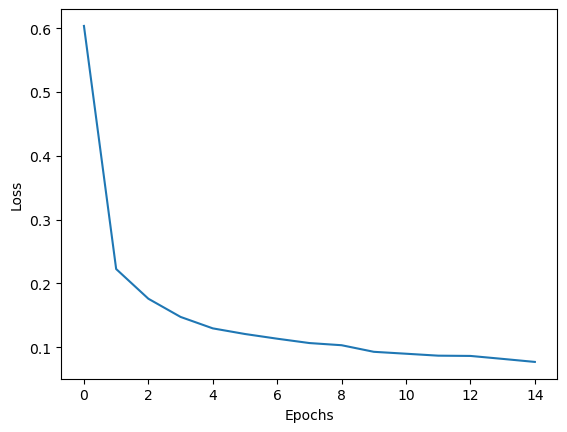

In [16]:
## Initialize the network parameters, loss function, optimizer, and device
mnist_dim = X.shape[1]
hidden_dim = int(mnist_dim/8)
output_dim = len(np.unique(mnist.target))

## Define the model, loss function, and optimizer
model = CNN(input_dim=mnist_dim, hidden_dim=hidden_dim, output_dim=output_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## Define the device to choose the fastest for training
## MPS for Apple Silicon, CUDA for NVidia GPUs, and CPU otherwise
device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'

## Define fit function
def fit(model, X_train, y_train, epochs=100):

    dataloader = DataLoader(dataset=TensorDataset(X_train, y_train), batch_size=128, shuffle=True, drop_last=True)
    model.to(device)

    ## set the model to training mode
    model.train()
    losses = []
    for epoch in range(epochs):
        loss = 0
        for X_train, y_train in tqdm(dataloader, desc=f'Training Epoch {epoch+1}/{epochs}'):
            X_train = X_train.to(device)
            y_train = y_train.to(device)
            ## zero the gradients
            optimizer.zero_grad()

            ## get the model predictions
            outputs = model(X_train)
            ## calculate the loss
            batch_loss = criterion(outputs, y_train)
            ## update the weights
            batch_loss.backward()
            optimizer.step()

            loss += batch_loss.item()

        # average loss per batch
        loss = loss / len(dataloader)
        losses.append(loss)

        print(f'Epoch {epoch+1}/{epochs}: Loss: {loss:.4f}')

    return losses

## Define predict function
def predict(model, X):

    dataloader = DataLoader(dataset=TensorDataset(X), batch_size=128, drop_last=False)

    ## set the model to evaluation mode
    model.eval()
    device = next(model.parameters()).device
    with torch.no_grad():
        predicted = []
        for X, in tqdm(dataloader, desc='Predicting'):
            X = X.to(device)

            ## get the model predictions
            outputs = model(X)
            
            _, predicted_batch = torch.max(outputs, 1)
            predicted.append(predicted_batch.cpu())
    return torch.cat(predicted)

## Train the model
losses = fit(model, X_train_tensor, y_train_tensor, epochs=15)

## Plot the loss
plt.figure()
plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

Predicting: 100%|██████████| 165/165 [00:00<00:00, 179.11it/s]


Accuracy: 0.9883


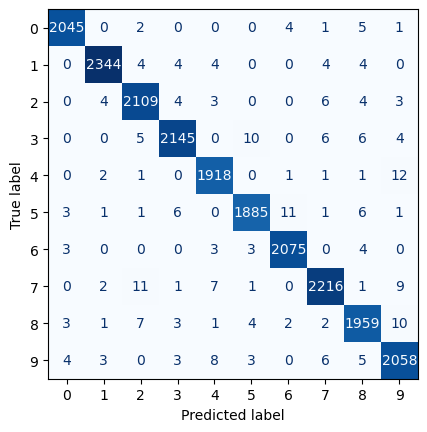

In [17]:
## Predict on the test set
y_pred_tensor = predict(model, X_test_tensor)
y_pred = y_pred_tensor.numpy()

## Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

## Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=np.arange(len(np.unique(y))))
disp.plot(cmap=plt.cm.Blues, values_format='d', colorbar=False);

- What accuracy did you get? Is it better than the fully connected network?

An accuracy of >98% should suffice for this example!

Let's take a look at some predictions that went wrong:

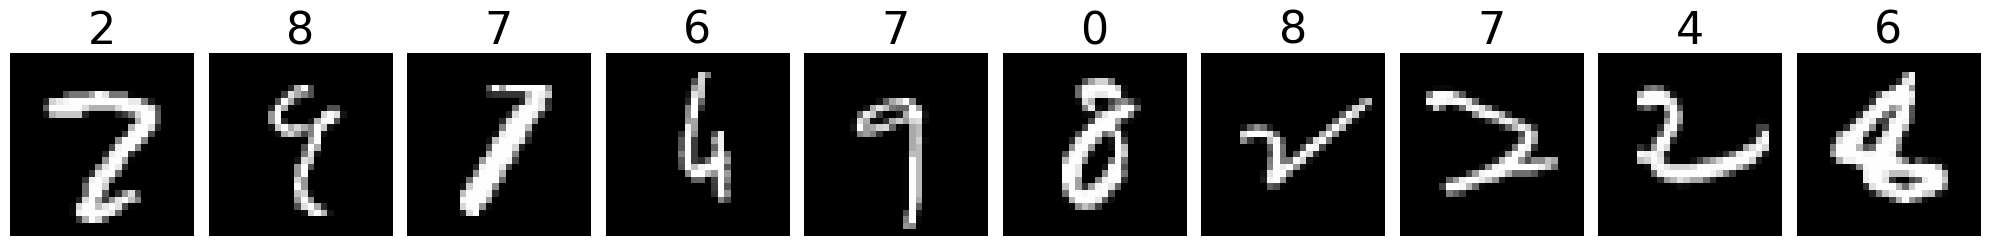

In [18]:
error_mask_cnn = y_pred != y_test
plot_example(X_test[error_mask_cnn], y_pred[error_mask_cnn], n_samples=10)

- Let's further look at the accuracy of the convolutional network model (CNN) on the misclassified examples previously by the fully connected network (FCN).

In [19]:
accuracy = accuracy_score(y_test[error_mask_fcn], y_pred[error_mask_fcn])
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.7318


About 70% of the previously misclassified images are now correctly identified. 

Let's take a look at some of the misclassified examples before:

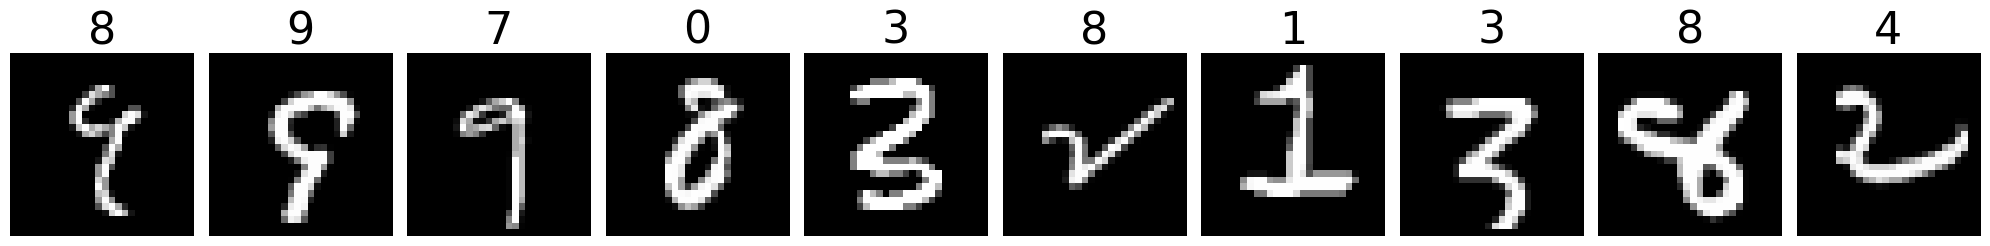

In [20]:
plot_example(X_test[error_mask_fcn], y_pred[error_mask_fcn])

- Last questions. Please take a look at the training loops of the fully connected network and the convolutional network. Comment on the similarities and differences.

You can see although the network architecture is different, the training loops are very similar. 

This is one feature of neural networks models. You can build significantly larger models and train them efficiently with a similar training loop, as long as you have enough computational power.   

Bonus points: One challenge in deep learning training is to find the proper hyperparameters. There are many hyperparameters to tune, such as the learning rate, the number of hidden layers, the number of neurons in each layer, the batch size, the number of epochs, etc.

Try to tune the hyperparameters of the convolutional network model to achieve a higher accuracy. For the MNIST dataset, an accuracy of >99% is possible with the LeNet architecture. Could you achieve this?